<a href="https://colab.research.google.com/github/abhishekshakya/seq-2-seq-for-neural-machine-translation-english-to-hindi-/blob/master/machineTranslation(attention).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('hindi_english_parallel.csv')
df.head()

,hindi,english
0,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,Give your application an accessibility workout
1,एक्सेर्साइसर पहुंचनीयता अन्वेषक,Accerciser Accessibility Explorer
2,निचले पटल के लिए डिफोल्ट प्लग-इन खाका,The default plugin layout for the bottom panel
3,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका,The default plugin layout for the top panel
4,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...,A list of plugins that are disabled by default


In [3]:
# df.drop(columns=['source'],inplace=True)

In [4]:
df = df.iloc[:30000,:]
df.head()
df.shape

(30000, 2)

In [5]:
def cleanerEng(x):
  x = str(x)
  x = x.lower()
  x = re.sub(r'[^a-z0-9]+',' ',x)
  if len(x) > 150:
    x = x[:150]
  return x

def cleanerHindi(x):
  x = str(x)
  x = re.sub(r'[-.।|,?;:<>&$₹]+',' ',x)
  if len(x) > 150:
    x = x[:150]
  return x

In [6]:
df['english'] = df['english'].apply(func=cleanerEng)
df['hindi']= df['hindi'].apply(func= cleanerHindi)
df['english']  = df['english'].apply(func= lambda x : (str(x).split()))
df['hindi'] = df['hindi'].apply(func= lambda x : (str(x).split()))

In [7]:
df.head()

,hindi,english
0,"[अपने, अनुप्रयोग, को, पहुंचनीयता, व्यायाम, का,...","[give, your, application, an, accessibility, w..."
1,"[एक्सेर्साइसर, पहुंचनीयता, अन्वेषक]","[accerciser, accessibility, explorer]"
2,"[निचले, पटल, के, लिए, डिफोल्ट, प्लग, इन, खाका]","[the, default, plugin, layout, for, the, botto..."
3,"[ऊपरी, पटल, के, लिए, डिफोल्ट, प्लग, इन, खाका]","[the, default, plugin, layout, for, the, top, ..."
4,"[उन, प्लग, इनों, की, सूची, जिन्हें, डिफोल्ट, र...","[a, list, of, plugins, that, are, disabled, by..."


In [8]:
def addTokens(x, start=False):
    if len(x) > 0:
        x.append('<eos>')
        if start:
            x.insert(0, '<sos>')
    else:
        x = ['<eos>'] if not start else ['<sos>', '<eos>']
    return list(x)


In [9]:
df['english'] = df['english'].apply(func= addTokens,start=False)
df['hindi']= df['hindi'].apply(func= addTokens,start=True)

In [10]:
data=df.values
data[0]

array([list(['<sos>', 'अपने', 'अनुप्रयोग', 'को', 'पहुंचनीयता', 'व्यायाम', 'का', 'लाभ', 'दें', '<eos>']),
       list(['give', 'your', 'application', 'an', 'accessibility', 'workout', '<eos>'])],
      dtype=object)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random

In [12]:
data = df.values
data[0][0]

['<sos>',
 'अपने',
 'अनुप्रयोग',
 'को',
 'पहुंचनीयता',
 'व्यायाम',
 'का',
 'लाभ',
 'दें',
 '<eos>']

In [13]:
data[:,1].shape

(30000,)

In [14]:
# class vocab:

#   def __init__(self,data,token=True):
#     self.data = data
#     if token:
#       self.word2idx = {'<START>':1, '<END>':2, '<PAD>':0}
#       self.idx2word = {1:'<START>', 2:'<END>', 0:'<PAD>'}
#       self.idx = 2

#     else:
#       self.word2idx = {'<PAD>':0, '<END>':1}
#       self.idx2word = {0:'<PAD>', 1:'<END>'}
#       self.idx = 1

#     self.x = []
#     self.create()
#     self.vocab_size = self.idx + 1

#   def create(self):
#     max_len = 0;
#     for sentence in  self.data:
#       max_len = max(max_len, len(sentence))
#       for word in sentence:
#         if self.word2idx.get(word) is None:
#           self.idx += 1
#           self.word2idx[word] = self.idx
#           self.idx2word[self.idx] = word
    
#     for sentence in self.data:
#       sent = []
#       for word in sentence:
#         sent.append(self.word2idx[word])
      
#       for i in range(len(sentence),max_len+1):
#         sent.append(0)
      
#       self.x.append(torch.Tensor(sent))

    

In [15]:
import torch

class Vocab:
    def __init__(self, data, token=True):
        self.data = data
        
        if token:
            # Reserve special tokens for target language
            self.word2idx = {'<pad>': 0, '<sos>': 1, '<eos>': 2}
            self.idx2word = {0: '<pad>', 1: '<sos>', 2: '<eos>'}
            self.idx = 2  # Start from 2 since 0, 1, 2 are taken by special tokens
        else:
            # Reserve <pad> token for source language (English)
            self.word2idx = {'<pad>': 0}
            self.idx2word = {0: '<pad>'}
            self.idx = 0  # Start from 0 since only <pad> is reserved

        self.x = []
        self.max_len = 0
        self.create()
        self.vocab_size = self.idx + 1  # Final vocabulary size

    def create(self):
        # Determine max length of sentences
        for sentence in self.data:
            self.max_len = max(self.max_len, len(sentence))
            for word in sentence:
                if self.word2idx.get(word) is None:
                    self.idx += 1
                    self.word2idx[word] = self.idx
                    self.idx2word[self.idx] = word
        
        # Tokenize and pad sentences
        for sentence in self.data:
            sent = [self.word2idx[word] for word in sentence]  # Convert words to indices
            
            # Add padding tokens
            sent += [self.word2idx['<pad>']] * (self.max_len - len(sentence))
            
            self.x.append(torch.LongTensor(sent))  # Convert to LongTensor for indexing

# Example Usage
English_vocab = Vocab(data[:, 1], token=False)  # English source language
Hindi_vocab = Vocab(data[:, 0], token=True)  # Hindi target language


In [16]:
data[:, 0]

array([list(['<sos>', 'अपने', 'अनुप्रयोग', 'को', 'पहुंचनीयता', 'व्यायाम', 'का', 'लाभ', 'दें', '<eos>']),
       list(['<sos>', 'एक्सेर्साइसर', 'पहुंचनीयता', 'अन्वेषक', '<eos>']),
       list(['<sos>', 'निचले', 'पटल', 'के', 'लिए', 'डिफोल्ट', 'प्लग', 'इन', 'खाका', '<eos>']),
       ...,
       list(['<sos>', 'क्या', 'आप', "'%", "s'", 'से', 'सत्र', 'आयात', 'करना', 'चाहते', 'हैं', '<eos>']),
       list(['<sos>', 'उस', 'तरह', 'से', 'पिछले', 'सत्र', 'से', 'पुरानी', 'फाइलें', 'लिखने', 'के', 'बाद', 'प्रयोग', 'लायक', 'होगी', '<eos>']),
       list(['<sos>', 'सत्र', 'आयात', 'करें', '(_', 'm)', '<eos>'])],
      dtype=object)

In [17]:
for idx in Hindi_vocab.x[2]:
  print(Hindi_vocab.idx2word[int(idx)],end=' ')
  
print("----")
print("Hindi vocab size=",Hindi_vocab.vocab_size)
print("eng vocab size=",English_vocab.vocab_size)


print("Hindi Vocabulary Size:", Hindi_vocab.vocab_size)
print("Hindi Word to Index Mapping:", Hindi_vocab.word2idx)
print("Hindi Index to Word Mapping:", Hindi_vocab.idx2word)



<sos> निचले पटल के लिए डिफोल्ट प्लग इन खाका <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> ----
Hindi vocab size= 3841
eng vocab size= 2630
Hindi Vocabulary Size: 3841
Hindi Word to Index Mapping: {'<pad>': 0, '<sos>': 1, '<eos>': 2, 'अपने': 3, 'अनुप्रयोग': 4, 'को': 5, 'पहुंचनीयता': 6, 'व्यायाम': 7, 'का': 8, 'लाभ': 9, 'दें': 10, 'एक्सेर्साइसर': 11, 'अन्वेषक': 12, 'निचले': 13, 'पटल': 14, 'के': 15, 'लिए': 16, 'डिफोल्ट': 17, 'प्लग': 18, 'इन': 19, 'खाका': 20, 'ऊपरी': 21, 'उन': 22, 'इनों': 23, 'की': 24, 'सूची': 25, 'जिन्हें': 26, 'रूप': 27, 'से': 28, 'निष्क्रिय': 29, 'किया': 30, 'गया': 31, 'है': 32, 'अवधि': 33, 'हाइलाइट': 34, 'रकें': 35, 'पहुंचनीय': 36, 'आसंधि': 37, '(नोड)': 38, 'चुनते': 39, 'समय': 40, 'बक्से': 41, 'सीमांत': 42, '(बोर्डर)': 43, 'रंग': 44, 'करें': 45, 'किए': 46, 'गए': 47, 'और': 48, 'अपारदर्शिता': 49, 'भराई': 50, 'प

In [18]:
print("Hindi Vocabulary Size:", Hindi_vocab.vocab_size)
print("Hindi Word to Index Mapping:", Hindi_vocab.word2idx)
print("Hindi Index to Word Mapping:", Hindi_vocab.idx2word)

Hindi Vocabulary Size: 3841
Hindi Word to Index Mapping: {'<pad>': 0, '<sos>': 1, '<eos>': 2, 'अपने': 3, 'अनुप्रयोग': 4, 'को': 5, 'पहुंचनीयता': 6, 'व्यायाम': 7, 'का': 8, 'लाभ': 9, 'दें': 10, 'एक्सेर्साइसर': 11, 'अन्वेषक': 12, 'निचले': 13, 'पटल': 14, 'के': 15, 'लिए': 16, 'डिफोल्ट': 17, 'प्लग': 18, 'इन': 19, 'खाका': 20, 'ऊपरी': 21, 'उन': 22, 'इनों': 23, 'की': 24, 'सूची': 25, 'जिन्हें': 26, 'रूप': 27, 'से': 28, 'निष्क्रिय': 29, 'किया': 30, 'गया': 31, 'है': 32, 'अवधि': 33, 'हाइलाइट': 34, 'रकें': 35, 'पहुंचनीय': 36, 'आसंधि': 37, '(नोड)': 38, 'चुनते': 39, 'समय': 40, 'बक्से': 41, 'सीमांत': 42, '(बोर्डर)': 43, 'रंग': 44, 'करें': 45, 'किए': 46, 'गए': 47, 'और': 48, 'अपारदर्शिता': 49, 'भराई': 50, 'पारदर्शिता': 51, 'एपीआई': 52, 'विचरक': 53, 'इस': 54, 'जिसे': 55, 'प्राप्त': 56, 'हो': 57, 'उसकी': 58, 'विभिन्न': 59, 'विधियों': 60, '(मेथड)': 61, 'में': 62, 'विचरण': 63, 'निजी': 64, 'गुणों': 65, 'छिपाएं': 66, 'विधि': 67, 'गुणधर्म': 68, 'मान': 69, 'आईपाइथन': 70, 'कन्सोल': 71, 'चुने': 72, 'एक्सेसेबेल': 73

In [19]:
print("English Vocabulary Size:", English_vocab.vocab_size)
print("English Word to Index Mapping:", English_vocab.word2idx)
print("English Index to Word Mapping:", English_vocab.idx2word)

English Vocabulary Size: 2630
English Word to Index Mapping: {'<pad>': 0, 'give': 1, 'your': 2, 'application': 3, 'an': 4, 'accessibility': 5, 'workout': 6, '<eos>': 7, 'accerciser': 8, 'explorer': 9, 'the': 10, 'default': 11, 'plugin': 12, 'layout': 13, 'for': 14, 'bottom': 15, 'panel': 16, 'top': 17, 'a': 18, 'list': 19, 'of': 20, 'plugins': 21, 'that': 22, 'are': 23, 'disabled': 24, 'by': 25, 'highlight': 26, 'duration': 27, 'box': 28, 'when': 29, 'selecting': 30, 'accessible': 31, 'nodes': 32, 'border': 33, 'color': 34, 'and': 35, 'opacity': 36, 'fill': 37, 'api': 38, 'browser': 39, 'browse': 40, 'various': 41, 'methods': 42, 'current': 43, 'hide': 44, 'private': 45, 'attributes': 46, 'method': 47, 'property': 48, 'value': 49, 'ipython': 50, 'console': 51, 'interactive': 52, 'manipulating': 53, 'currently': 54, 'selected': 55, 'event': 56, 'monitor': 57, 'events': 58, 'c': 59, 'lear': 60, 'selection': 61, 'everything': 62, 'source': 63, 'shows': 64, 'as': 65, 'they': 66, 'occur': 6

In [20]:
from torch.nn.utils.rnn import pad_sequence

class parallelData(Dataset):
    def __init__(self):
        self.x = Hindi_vocab.x
        self.y = English_vocab.x

    def __getitem__(self,i):
        return self.x[i], self.y[i]
    
    def __len__(self):
        return len(self.x)

def collate_fn(batch):
    x_batch, y_batch = zip(*batch)
    # No need for padding since it's already handled in Vocab
    x_batch = torch.stack(x_batch, dim=0)  # Stack already padded tensors
    y_batch = torch.stack(y_batch, dim=0)
    return x_batch, y_batch


In [21]:
# Check the original sentence data
print("Original Data Hindi Sentence:", data[0][0])

# Instantiate parallelData
dataset = parallelData()
print(dataset[0])
print(len(dataset))

# Retrieve the indices tensor for the first sample
indices_tensor = dataset[0][0]

# Convert indices tensor to a list of indices
indices = indices_tensor.tolist()

# Map indices to words using idx2word
words = [Hindi_vocab.idx2word.get(idx, '<unknown>') for idx in indices]

# Print the resulting words
print("Converted Words from Dataset Indices:")
print(' '.join(words))

Original Data Hindi Sentence: ['<sos>', 'अपने', 'अनुप्रयोग', 'को', 'पहुंचनीयता', 'व्यायाम', 'का', 'लाभ', 'दें', '<eos>']
(tensor([ 1,  3,  4,  5,  6,  7,  8,  9, 10,  2,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]), tensor([1, 2, 3, 4, 5, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0]))
30000
Converted Words from Dataset Indices:
<sos> अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [22]:
# Original data
print("Original Data Hindi Sentence:", data[0][0])

# Data from parallelData class
print("Dataset Hindi Sentence:", dataset[0][0])


Original Data Hindi Sentence: ['<sos>', 'अपने', 'अनुप्रयोग', 'को', 'पहुंचनीयता', 'व्यायाम', 'का', 'लाभ', 'दें', '<eos>']
Dataset Hindi Sentence: tensor([ 1,  3,  4,  5,  6,  7,  8,  9, 10,  2,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0])


In [23]:
a = dataset[0][0].shape[0]
b = dataset[0][1].shape[0]
for i in range(len(dataset)):
  if a != dataset[i][0].shape[0] or b != dataset[i][1].shape[0]:
    print(a,dataset[i][0].shape[0],b,dataset[i][1].shape[0])

In [24]:
Hindi_vocab.x[5].shape

torch.Size([44])

In [25]:
torch.cuda.device_count()

2

In [26]:
#Model preparation

class encoder(nn.Module):

  def __init__(self, input_size, embedding_size, hidden_size, layers, bidirectional):
    '''
    input_size = size of vocab
    embedding_size = embedding dim
    hidden_size = hidden state size
    layer = num of layers of lstms
    '''
    super().__init__()
    self.embed = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size) # output size = (*,embedding_size)
    self.lstm = nn.LSTM(input_size=embedding_size, hidden_size= hidden_size, num_layers=layers, batch_first = True, bidirectional = bidirectional)
    self.bidirectional = bidirectional
    #in order to convert bidirectional hidden state to unidirectional if LSTM is bidirectional 
    self.fc_hidden = nn.Linear(hidden_size*2, hidden_size)
    self.fc_cell = nn.Linear(hidden_size*2, hidden_size)

  def forward(self,x):
    '''
    x shape = [batch_size, sentence]
    one complete sentence represents a "sequence"
    '''
    x = self.embed(x) # shape [batch_size,  sentence, embed_size]
    output, (hidden_state, cell_state) = self.lstm(x) #shape [batch_size, seq_len, num_directions(2)*hidden_size]

    if self.bidirectional:  #since we have 2 directions so add(concat) hidden of both directions into one
      hidden = torch.cat((hidden_state[0:1], hidden_state[1:2]), dim=2)
      cell = torch.cat((cell_state[0:1], cell_state[1:2]), dim = 2) #output [1(layer), batch, hidden_size*2]
      hidden_state = self.fc_hidden(hidden)
      cell_state = self.fc_cell(cell)

    # print(output.shape, x.shape)
    #output shape = [batch_size, seq_len, 2*hidden_size] 
    #hidden shape =[1(layers), batch_size, hidden_size]
    return output, hidden_state, cell_state



		
##_---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
class decoder(nn.Module):

  def __init__(self,input_size, embedding_size, hidden_size, layers):
    '''
    same configuration as encoder
    here input_size = size of hindi vocab
    '''
    super().__init__()
    self.embed = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size) # output size = (*,embedding_size)
    self.lstm = nn.LSTM(input_size=embedding_size, hidden_size= hidden_size, num_layers=layers, batch_first = True)
    self.fc = nn.Linear(in_features=hidden_size, out_features=input_size) #since output would be prob distribution among hindi vocab therefore out_feature=input_size

  def forward(self,x,hidden_state, cell_state):
    '''
    to have control over output we have to take sentence as word by word
    therefore seq_len would be 1 as input is  one word not the whole sentence
    x = [batch_size] ->required-> [batch_size, 1] (1 is seq_len)
    '''
    # print(x.shape)
    x = x.reshape(-1,1) # shape [batch, 1]
    # print(x.shape)
    x = self.embed(x) # shape [batch, 1, embed_dim]

    output, (hidden_state, cell_state) = self.lstm(x, (hidden_state, cell_state)) # shape output=>[batch, 1, hidden_size], hidden=>[layers, batch, hidden_size]
    output = self.fc(output) # shape [batch, 1, hindi_vocab_size]
    
    #just for removing extra dim
    output = output.squeeze(dim=1) #shape [batch, hindi_vocab_size]

    return output, hidden_state, cell_state


##_---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

class AttnDecoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, layers):
    super().__init__()

    self.embed = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size) # output size = (*,embedding_size)
    self.lstm = nn.LSTM(input_size=hidden_size*2 + embedding_size, hidden_size= hidden_size, num_layers=layers, batch_first = True)
    self.fc = nn.Linear(in_features=hidden_size, out_features=input_size) #since output would be prob distribution among hindi vocab therefore out_feature=input_size

    #encoder_states from encoder => [batch, seq_len(35), 2*hidden_size]
    #prev decoder hidden_state => [batch, layers(1)*directions(2), hidden_size] =>need to be in => [batch, seq(35), hidden_size]
    #therefore input of energy will be along hidden_size ie input = hidden_size*2
    self.energy =  nn.Linear(hidden_size*3, 1) #out [batch, seq_len, 1] (2 hidden state from bidirectional encoder and 1 from prev decoder hidden state => 1+2= 3 hidden states as input)
    self.softmax = nn.Softmax(dim=1)# doing softmax for each word ie (dim=1)

  
  def forward(self, x, hidden_state, cell_state, encoder_states):
    # print(encoder_states.shape)
    seq_len = encoder_states.shape[1]
    batch_size = encoder_states.shape[0]
    hidden_size = encoder_states.shape[2]

    h_new = hidden_state.repeat(seq_len, 1, 1) #shape [seq_len*1, batch, hidden_size*2(bidirectional)] it will repeat dim=0 seq length times
    #by doing .repeat operation we can concat hidden state with all timestamps of encoder_states
    # print(h_new.shape, encoder_states.shape, hidden_state.shape)
    h_new = h_new.permute(1,0,2) #[batch, seq_len, hidden_size*2]
    energy = self.energy(torch.cat((h_new, encoder_states), dim=2))#input [batch, seq_len(35), hidden_size*3]  out = [batch, seq_len(35), 1]
    att_weights = self.softmax(energy)
    att_weights = att_weights.permute(0,2,1) # [batch, 1, seq_len]

    context = torch.bmm(att_weights, encoder_states) #[batch, 1, hidden_size*2]
    

    x = x.reshape(-1,1) # shape [batch, 1]
    x = self.embed(x) # shape [batch, 1, embed_dim]

    input_new = torch.cat((context, x), dim=2) #[batch, 1, hidden_size*2 +embed_dim]

    output, (hidden_state, cell_state) = self.lstm(input_new, (hidden_state, cell_state)) # shape output=>[batch, 1, hidden_size], hidden=>[layers, batch, hidden_size]
    output = self.fc(output) # shape [batch, 1, hindi_vocab_size]

    output = output.squeeze(dim=1) #shape [batch, hindi_vocab_size]
    del h_new
    del context
    del input_new
    return output, hidden_state, cell_state

##_---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

class seq2seq(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder


  def forward(self, input, target, teaching_force=0.5):
    '''
    input = batch of english sentences[batch, sentece(padded)]
    target = batch of hindi sentences [batch, sentence(padded)] 
    '''
    batch_size = input.shape[0]
    seq_len = target.shape[1]
    hindi_vocab_size = Hindi_vocab.vocab_size

    output = torch.zeros((seq_len, batch_size, hindi_vocab_size)).to(device)

    _, hidden, cell = self.encoder(input)
    target = target.permute(1,0) # shape [seq, batch]
    x = target[0] # <START> token

    for i in range(1, seq_len):
      out, hidden, cell = self.decoder(x, hidden, cell) #out shape = [batch, vocab_size]
      output[i] = out
      decoder_guess = out.argmax(1)# taking the word with max value(confidence)  shape = [batch of words]

      if random.random() < teaching_force:
        x = target[i]
      else:
        x =  decoder_guess
    
    return output  #shape[seq_len, batch_size, vocab_size]

##_---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

class Attnseq2seq(nn.Module):
  def __init__(self, encoder, att_decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = att_decoder


  def forward(self, input, target, teaching_force=0.5):
    '''
    input = batch of english sentences[batch, sentece(padded)]
    target = batch of hindi sentences [batch, sentence(padded)] 
    '''
    batch_size = input.shape[0]
    seq_len = target.shape[1]
    hindi_vocab_size = Hindi_vocab.vocab_size

    output = torch.zeros((seq_len, batch_size, hindi_vocab_size)).to(device)

    encoder_states, hidden, cell = self.encoder(input)
    target = target.permute(1,0) # shape [seq, batch]
    x = target[0] # <START> token

    for i in range(1, seq_len):
      out, hidden, cell = self.decoder(x, hidden, cell, encoder_states) #out shape = [batch, vocab_size]
      output[i] = out
      decoder_guess = out.argmax(1)# taking the word with max value(confidence)  shape = [batch of words]

      if random.random() < teaching_force:
        x = target[i]
      else:
        x =  decoder_guess
    
    return output  #shape[seq_len, batch_size, vocab_size]



In [27]:
##training
epochs = 10
learning_rate = 0.0006
batch_size = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_size = 256
hidden_size = 256
layers = 1
bidirection = True


In [28]:
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [29]:
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print("No of batches:", len(loader))

for batch in loader:
    x_batch, y_batch = batch
    print("Shape of x_batch:", x_batch.shape)
    print("Shape of y_batch:", y_batch.shape)
    break  # Only need to check the shape of one batch

No of batches: 300
Shape of x_batch: torch.Size([100, 44])
Shape of y_batch: torch.Size([100, 33])


In [30]:
it = iter(loader)
x,y = next(it)
print(x.shape,y.shape)
len(dataset)


torch.Size([100, 44]) torch.Size([100, 33])


30000

In [32]:
ENC = encoder(English_vocab.vocab_size, embedding_size, hidden_size, layers, bidirection).to(device)
# DE = decoder(Hindi_vocab.vocab_size, embedding_size, hidden_size, layers).to(device)
DE = AttnDecoder(Hindi_vocab.vocab_size, embedding_size, hidden_size, layers).to(device)
# model = seq2seq(ENC,DE).to(device)
model = Attnseq2seq(ENC,DE).to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=0)


In [33]:
train_loss = []
for epoch in tqdm(range(epochs)):
  for id,(x,y) in (enumerate(tqdm(loader))):
    x = x.long().to(device)
    y = y.long().to(device)#[batch,seq]

    output = model(y,x,1)# [seq, batch, vocab]
    output = output[1:].reshape(-1,output.shape[2])
    x = x.permute(1,0)#[seq, batch]
    x = x[1:].reshape(-1)

    optimizer.zero_grad()
    loss = criterion(output,x)

    loss.backward()
    optimizer.step()

    # if id%20 == 0:
  print(f'[{epoch+1}/{epochs}] loss=>{loss.item()}')
  train_loss.append(loss.item())

  

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

[1/10] loss=>3.5056283473968506


  0%|          | 0/300 [00:00<?, ?it/s]

[2/10] loss=>2.858599901199341


  0%|          | 0/300 [00:00<?, ?it/s]

[3/10] loss=>1.8677259683609009


  0%|          | 0/300 [00:00<?, ?it/s]

[4/10] loss=>0.965355396270752


  0%|          | 0/300 [00:00<?, ?it/s]

[5/10] loss=>0.9700695276260376


  0%|          | 0/300 [00:00<?, ?it/s]

[6/10] loss=>0.5316601991653442


  0%|          | 0/300 [00:00<?, ?it/s]

[7/10] loss=>0.3742907643318176


  0%|          | 0/300 [00:00<?, ?it/s]

[8/10] loss=>0.5030005574226379


  0%|          | 0/300 [00:00<?, ?it/s]

[9/10] loss=>0.32112693786621094


  0%|          | 0/300 [00:00<?, ?it/s]

[10/10] loss=>0.2945583760738373


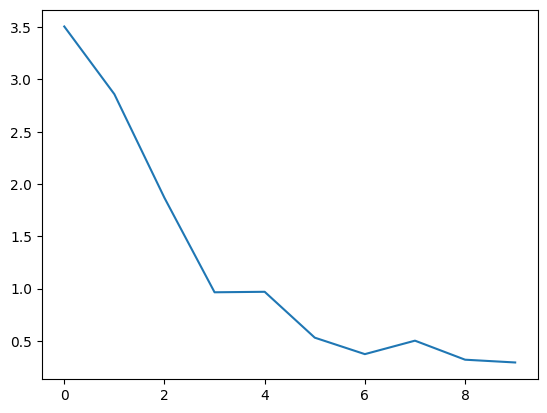

In [34]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.show()

In [35]:
torch.save(model.state_dict(),'model.pt')

In [36]:
def prediction(x):
    for idx in x:
      if idx == 0:
        break
      print(English_vocab.idx2word[int(idx)],end=' ')
    
    print()

    x = x.long().reshape(1,-1).to(device)
    ans = translate(x)
    res = []
    for id in ans:
      res.append(Hindi_vocab.idx2word[id])
    
    return res


In [37]:
def translate(input):
      #input = batch of english sentences[batch, sentece(padded)]
      with torch.no_grad():
        guess = []
        encoder_states, hidden, cell = model.encoder(input)
        # x = torch.ones((1)).float().to(device) # <START> token
        x = torch.ones((1)).long().to(device)
        while True:
          out, hidden, cell = model.decoder(x, hidden, cell, encoder_states) #out shape = [batch, vocab_size]
          x = out.argmax(1)# taking the word with max value(confidence)  shape = [batch of words]
          guess.append(int(x[0].detach().cpu()))

          if x == 2:
            break

      return guess

In [38]:
prediction(dataset[50][1])

co mponent <eos> 


['घटक', '<eos>']

In [39]:
prediction(dataset[100][1])

script recorder <eos> 


['लिपि', 'रेकोर्डर', '<eos>']

In [40]:
prediction(dataset[71][1])

extents <eos> 


['विस्तारः', '<eos>']

In [41]:
prediction(dataset[random.randint(0,5)][1])

accerciser accessibility explorer <eos> 


['एक्सेर्साइसर', 'पहुंचनीयता', 'अन्वेषक', '<eos>']

In [42]:
for i in range(15):
  p=prediction(dataset[random.randint(0,10000)][1])
  print(p)

show or hide statusbar <eos> 
['उपकरण', 'पट्टी', 'छुपाएँ', 'या', 'दिखाएँ', '<eos>']
anjuta home page <eos> 
['Anjuta', 'घर', 'पेज', '(_', 'H)', '<eos>']
s on waste <eos> 
['%', 's', 'अपशिष्ट', 'पर', '<eos>']
the layout for the bottom panel <eos> 
['नीचे', 'के', 'पैनल', 'के', 'लिए', 'लेआउट', '<eos>']
cyrillic russian <eos> 
['साइरिलिक/रूसी', '<eos>']
make d leaving directory s <eos> 
['कार्यकारी', 'डायरेक्टरी', '<eos>']
event monitor <eos> 
['घटना', 'मानिटर', '<eos>']
accerciser <eos> 
['एक्सेर्साइसर', '<eos>']
the six of spades <eos> 
['हुकुम', 'का', 'छक्का', '<eos>']
remove the eight of hearts <eos> 
['लाल', 'पान', 'का', 'बादशाह', 'हटाएँ', '<eos>']
alpha <eos> 
['अल्फा', '<eos>']
remove the ten of spades <eos> 
['हुकुम', 'का', 'दहला', '<eos>']
central european <eos> 
['मध्य', 'यूरोपीय', '<eos>']
ins <eos> 
['प्रविष्ट', '<eos>']
the jack of spades <eos> 
['हुकुम', 'का', 'गुलाम', '<eos>']


In [43]:
dataset[3][1]

tensor([10, 11, 12, 13, 14, 10, 17, 16,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [44]:
def get(sent):
  # sentence = sentence.lower()
  # sent = sentence.split()
  # sent.append('<END>')
  # print(sent)

  toks = []
  for word in sent:
    if English_vocab.word2idx.get(word) is None:
      toks.append(English_vocab.word2idx['the'])
    else:
      toks.append(English_vocab.word2idx[word])
  # print(toks)
  sent = torch.tensor(toks).float()
  res = prediction(sent)
  # print(res)
  return res

In [45]:
#bleu score calculation

In [46]:
df2 = pd.read_csv('hindi_english_parallel.csv')
df2 = df2.iloc[30001:31000,:]
df2.head()

,hindi,english
30001,कृपया प्रतीक्षा करें जबकि परियोजना लोड कर रहा ...,Please wait while the project is loading.
30002,लोड करना रद्द करें (_ C),_ Cancel Loading
30003,मौजूदा परियोजना की लोडिंग रद्द करें,Cancel loading current project
30004,फ़ाइल का पुनर्नामकरण,File Renaming
30005,नाम बदलें (_ R),_ Rename


In [47]:
df2 = df2[['hindi', 'english']].copy()
df2['english'] = df2['english'].apply(func=cleanerEng)
df2['hindi']= df2['hindi'].apply(func= cleanerHindi)
df2['english']  = df2['english'].apply(func= lambda x : (str(x).split()))
df2['hindi'] = df2['hindi'].apply(func= lambda x : (str(x).split()))

In [48]:
df2.head()

,hindi,english
30001,"[कृपया, प्रतीक्षा, करें, जबकि, परियोजना, लोड, ...","[please, wait, while, the, project, is, loading]"
30002,"[लोड, करना, रद्द, करें, (_, C)]","[cancel, loading]"
30003,"[मौजूदा, परियोजना, की, लोडिंग, रद्द, करें]","[cancel, loading, current, project]"
30004,"[फ़ाइल, का, पुनर्नामकरण]","[file, renaming]"
30005,"[नाम, बदलें, (_, R)]",[rename]


In [49]:
df2['english'] = df2['english'].apply(func= addTokens,start=False)
df2['hindi']= df2['hindi'].apply(func= addTokens,start=True)

In [50]:
df2.head()

,hindi,english
30001,"[<sos>, कृपया, प्रतीक्षा, करें, जबकि, परियोजना...","[please, wait, while, the, project, is, loadin..."
30002,"[<sos>, लोड, करना, रद्द, करें, (_, C), <eos>]","[cancel, loading, <eos>]"
30003,"[<sos>, मौजूदा, परियोजना, की, लोडिंग, रद्द, कर...","[cancel, loading, current, project, <eos>]"
30004,"[<sos>, फ़ाइल, का, पुनर्नामकरण, <eos>]","[file, renaming, <eos>]"
30005,"[<sos>, नाम, बदलें, (_, R), <eos>]","[rename, <eos>]"


In [51]:
tdata = df2.values
print(tdata[0])
test_dataset = Vocab(tdata[:,1],token=False)

[list(['<sos>', 'कृपया', 'प्रतीक्षा', 'करें', 'जबकि', 'परियोजना', 'लोड', 'कर', 'रहा', 'है', '<eos>'])
 list(['please', 'wait', 'while', 'the', 'project', 'is', 'loading', '<eos>'])]


In [52]:
print(tdata[157])

[list(['<sos>', 'गीतसूची', 'का', 'पथ', '<eos>'])
 list(['path', 'to', 'playlist', '<eos>'])]


In [53]:
print(tdata[157,1][:-1])

['path', 'to', 'playlist']


In [54]:

for i in range(15):
  p=get(tdata[i][1])
  print("original:",tdata[i][0])
  print("predicted:",p)


please wait while the project is loading <eos> 
original: ['<sos>', 'कृपया', 'प्रतीक्षा', 'करें', 'जबकि', 'परियोजना', 'लोड', 'कर', 'रहा', 'है', '<eos>']
predicted: ['कृपया', 'डिस्क', 'है', 'से', 'नहीं', '<eos>']
cancel loading <eos> 
original: ['<sos>', 'लोड', 'करना', 'रद्द', 'करें', '(_', 'C)', '<eos>']
predicted: ['लोड', 'हो', 'रहा', 'है', 'जब', 'और', 'इसकी', 'ब्रैसेरो', 'को', 'करेगा', '<eos>']
cancel loading current project <eos> 
original: ['<sos>', 'मौजूदा', 'परियोजना', 'की', 'लोडिंग', 'रद्द', 'करें', '<eos>']
predicted: ['प्रोजेक्ट', 'बंद', 'करें', '<eos>']
file renaming <eos> 
original: ['<sos>', 'फ़ाइल', 'का', 'पुनर्नामकरण', '<eos>']
predicted: ['फ़ाइल', '<eos>']
rename <eos> 
original: ['<sos>', 'नाम', 'बदलें', '(_', 'R)', '<eos>']
predicted: ['नाम', 'बदलें', '<eos>']
renaming mode <eos> 
original: ['<sos>', 'पुनर्नामकरण', 'मोड', '<eos>']
predicted: ['नहीं', 'है', '<eos>']
size <eos> 
original: ['<sos>', 'आकार', '<eos>']
predicted: ['आकार', '<eos>']
space <eos> 
original: ['<s